# Exploratory analysis and Feature Engineering

Now that we have the data, let's explore it, clean it and create features for the machine learning model.
<br>
<h3>Goals:</h3> <br>
<b>1 - Understand the data we collected.</b> <br>
For this part, we will use pandas and matpyplot libs. <br>
<br>
<b>2 - Clean null values and irrelevant characters.</b> <br>
We will use apply with custom functions and RegEx.<br>
<br>
<b>3 - Transform the text data into features we can use.</b> <br>
We will create features and evaluate their correlation and importance (seaborn and  sklearn).<br>
<br>
<b>4 - Tolkenize data.</b><br>
TfidfVectorizer from sklearn.feature_extraction.text.<br>


In [68]:
from sklearn.preprocessing import normalize 

In [69]:
# Importing the libraries

# Manipulating the data
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Data vizualization
import matplotlib.pyplot as plt
import seaborn as sns

# Feature engineering evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Saving the output
import datetime

<h4>Functions</h4>

In [70]:
# removes chars from a string, based on a list
def remove_char(text,list_of_chars):
    for char in list_of_chars:
        text = text.replace(char,'')
    return text

# if a text is duplicated in two columns, remove it from the one passed as first arg
def extract_href(x):
    if type(x[1]) != str:
        return x[0]
    else:
        return x[0].replace(x[1],'')
    
def specialCharCleaner(x):
        
    x = re.sub(r'[?|$|.|!]',r' ',str(x)) 
    x = re.sub(r'[^a-zA-Z0-9 ]',r' ',str(x))
    x = re.sub('  ',' ',str(x))
            
    return x

def remove_numbers(x):
    x =''.join(c if c not in map(str,range(0,10)) else '' for c in str(x)) #for remove numbers
    for i in range(3):
        x = re.sub('  ',' ',str(x)) # remove extra espaces
    return x

# concats multiple coluns
def connect_columns(x):
    return str(x[0]) + ' ' + str(x[1]) + ' ' + str(x[2]) + ' ' + str(x[3])

# Just to make the notebook more organized
def heat_map(df):
    corr = df.corr()
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )

We have two different sources of data, so let's load and put them all together in a single dataframe

In [71]:
# Importing HTML rendered links
dfHTML = pd.read_csv(r'training_data_set_HTML 2020-11-13 14h35.csv')
dfHTML = dfHTML.drop('jobPostCheck', axis='columns')

# Importing JS rendered links
dfJS = pd.read_csv(r'training_data_set_js 2020-11-13 15h19.csv')


# Concating both DataFrames
print('lenght df html: ', len(dfHTML.index))
print('lenght df JS: ', len(dfJS.index))

frames = [dfHTML,dfJS]

df = pd.concat(frames,ignore_index=True)
print('Final len: ', len(df.index))

lenght df html:  4533
lenght df JS:  2059
Final len:  6592


In [72]:
df.head()

,company,url,aTag,aTagText,aTagContent,href,keys,attributes,key_attr,trun_href,candidateMatch
0,shopify,https://www.shopify.ca/careers/search,"<a class=""in-page-link skip-to-main visuallyhi...","<a class=""in-page-link skip-to-main visuallyhi...",Skip to Content,#Main,"dict_keys(['class', 'data-ga-event', 'data-ga-...","dict_values([['in-page-link', 'skip-to-main', ...","{'class': ['in-page-link', 'skip-to-main', 'vi...",#Main,0.0
1,shopify,https://www.shopify.ca/careers/search,"<a class=""marketing-nav__logo__shopify"" data-g...","<a class=""marketing-nav__logo__shopify"" data-g...",\nShopify Careers \n,/careers,"dict_keys(['href', 'class', 'data-ga-event', '...","dict_values(['/careers', ['marketing-nav__logo...","{'href': '/careers', 'class': ['marketing-nav_...",/careers,0.0
2,shopify,https://www.shopify.ca/careers/search,"<a class=""marketing-nav__item marketing-nav__i...","<a class=""marketing-nav__item marketing-nav__i...",Life at Shopify,/careers/culture,"dict_keys(['href', 'class', 'itemprop'])","dict_values(['/careers/culture', ['marketing-n...","{'href': '/careers/culture', 'class': ['market...",/careers/culture,0.0
3,shopify,https://www.shopify.ca/careers/search,"<a class=""marketing-nav__item marketing-nav__i...","<a class=""marketing-nav__item marketing-nav__i...",Teams,/careers/teams,"dict_keys(['href', 'class', 'itemprop'])","dict_values(['/careers/teams', ['marketing-nav...","{'href': '/careers/teams', 'class': ['marketin...",/careers/teams,0.0
4,shopify,https://www.shopify.ca/careers/search,"<a class=""marketing-nav__item marketing-nav__i...","<a class=""marketing-nav__item marketing-nav__i...",Work anywhere,/careers/work-anywhere,"dict_keys(['href', 'class', 'itemprop'])","dict_values(['/careers/work-anywhere', ['marke...","{'href': '/careers/work-anywhere', 'class': ['...",/careers/work-anywhere,0.0


In [73]:
df.columns

# company -> employer
# url -> url from the website the data was pulled from
# aTag -> entire tag 'a' that contains the link we want to evaluate
# aTagText -> same as above, but with a different approach to extract
# aTagContent -> the text that is displayed in the website (extracted from the tag 'a')
# href -> the link we want to evaluate (extracted from the tag 'a')
# keys -> all the keys of the element tag
# attributes -> all attributes associated with the keys from the tag
# key_attr -> keys and attributes, in a dict format
# trun_href -> the truncated href
# candidateMatch -> indicates if the link is a job posting or not - 0 or 1

Index(['company', 'url', 'aTag', 'aTagText', 'aTagContent', 'href', 'keys',
       'attributes', 'key_attr', 'trun_href', 'candidateMatch'],
      dtype='object')

In [77]:
# Everything was loaded as objects, if we get any trouble ahead we will handle this

df.dtypes

company            object
url                object
aTag               object
aTagText           object
aTagContent        object
href               object
keys               object
attributes         object
key_attr           object
trun_href          object
candidateMatch    float64
dtype: object

In [78]:
df.isna().sum()

company             0
url                 0
aTag                0
aTagText            0
aTagContent       143
href               82
keys                0
attributes          0
key_attr            0
trun_href           0
candidateMatch      0
dtype: int64

<h4>We have a lot of null values for aTagContent and href. The first one should not be a problem for now. For the latter, it does not make sense to carry data that does not have a link, so let's drop those rows</h4>

In [79]:
row_drop = df[df.href.isna()].index
df.drop(row_drop,axis='rows',inplace=True)
df.reset_index(drop=True,inplace=True)

In [80]:
df.isna().sum()

company             0
url                 0
aTag                0
aTagText            0
aTagContent       127
href                0
keys                0
attributes          0
key_attr            0
trun_href           0
candidateMatch      0
dtype: int64

<h4>Let's take a look on the distribution of data by company</h4>

Only 43% of the data is composed by real job posts. That is surprising, since all links were extracted from career webpages. Facebook represents half of the dataset, so we need to be careful not to create features that may overfit our model.

In [81]:
pd.crosstab(df['company'],df['candidateMatch'],margins=True,margins_name='Total',normalize=True).sort_values(by='Total', ascending=False)

candidateMatch,0.0,1.0,Total
company,,,
Total,0.565745,0.434255,1.000000
Facebook,0.213518,0.199693,0.413210
scotiabank,0.086022,0.061444,0.147465
Okta,0.025346,0.045622,0.070968
square,0.001690,0.045161,0.046851
glu,0.017358,0.011982,0.029339
klick,0.014593,0.010753,0.025346
Oracle,0.020276,0.003840,0.024117
opentext,0.023810,0.000000,0.023810


Google, walmart, opentext, ecobee and rubikloud.ai have no job openings. Probably there was a problem while scraping those pages. 

In [82]:
# Creating a copy of df for backup purposes
df_backup = df.copy()

Let's save the dataframe to keep track of the data we are classifying

In [83]:
now = datetime.datetime.now()
today = datetime.datetime.today()

date = today.strftime("%Y-%m-%d")
hour = now.strftime("%H")
minute = now.strftime("%M")

stamp = str(date) + ' ' + str(hour) + 'h' + str(minute)

df_backup.to_csv(r'dataset_before_col_drop'+str(stamp)+'.csv',index=False)

'company' and 'url' should add no value for the model because they will not help in the classification. Also, 'aTag' and 'aTagtext' have all their data duplicated in other columns, such as keys and attributes.

In [84]:
df = df.drop(['company','url','aTag','aTagText'],axis='columns')

In [85]:
df.head()

,aTagContent,href,keys,attributes,key_attr,trun_href,candidateMatch
0,Skip to Content,#Main,"dict_keys(['class', 'data-ga-event', 'data-ga-...","dict_values([['in-page-link', 'skip-to-main', ...","{'class': ['in-page-link', 'skip-to-main', 'vi...",#Main,0.0
1,\nShopify Careers \n,/careers,"dict_keys(['href', 'class', 'data-ga-event', '...","dict_values(['/careers', ['marketing-nav__logo...","{'href': '/careers', 'class': ['marketing-nav_...",/careers,0.0
2,Life at Shopify,/careers/culture,"dict_keys(['href', 'class', 'itemprop'])","dict_values(['/careers/culture', ['marketing-n...","{'href': '/careers/culture', 'class': ['market...",/careers/culture,0.0
3,Teams,/careers/teams,"dict_keys(['href', 'class', 'itemprop'])","dict_values(['/careers/teams', ['marketing-nav...","{'href': '/careers/teams', 'class': ['marketin...",/careers/teams,0.0
4,Work anywhere,/careers/work-anywhere,"dict_keys(['href', 'class', 'itemprop'])","dict_values(['/careers/work-anywhere', ['marke...","{'href': '/careers/work-anywhere', 'class': ['...",/careers/work-anywhere,0.0


There is a lot of data to be cleaned, so let's walk throught each column

# aTagContet

We are going to do three things here: <br>
1 - Create a length feature <br>
2 - Group the length

In [86]:
# Creating the length feature
df['len_aTagContent'] = df['aTagContent'].apply(lambda x: len(x) if type(x) == str else 0)

In [87]:
df.head()

,aTagContent,href,keys,attributes,key_attr,trun_href,candidateMatch,len_aTagContent
0,Skip to Content,#Main,"dict_keys(['class', 'data-ga-event', 'data-ga-...","dict_values([['in-page-link', 'skip-to-main', ...","{'class': ['in-page-link', 'skip-to-main', 'vi...",#Main,0.0,15
1,\nShopify Careers \n,/careers,"dict_keys(['href', 'class', 'data-ga-event', '...","dict_values(['/careers', ['marketing-nav__logo...","{'href': '/careers', 'class': ['marketing-nav_...",/careers,0.0,19
2,Life at Shopify,/careers/culture,"dict_keys(['href', 'class', 'itemprop'])","dict_values(['/careers/culture', ['marketing-n...","{'href': '/careers/culture', 'class': ['market...",/careers/culture,0.0,15
3,Teams,/careers/teams,"dict_keys(['href', 'class', 'itemprop'])","dict_values(['/careers/teams', ['marketing-nav...","{'href': '/careers/teams', 'class': ['marketin...",/careers/teams,0.0,5
4,Work anywhere,/careers/work-anywhere,"dict_keys(['href', 'class', 'itemprop'])","dict_values(['/careers/work-anywhere', ['marke...","{'href': '/careers/work-anywhere', 'class': ['...",/careers/work-anywhere,0.0,13


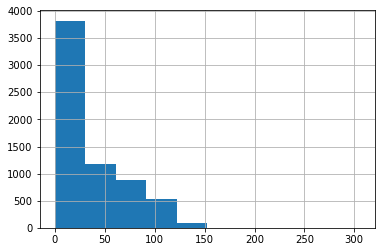

In [88]:
df.len_aTagContent.hist()

We can see that there are some outliers around 300. Also, we don't want the model to rely too much on this feature just because of its magnitude, so let's normalize it.

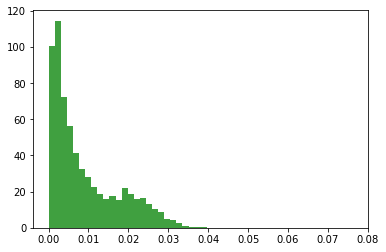

In [89]:
len_aTagContent_norm = normalize(df.len_aTagContent.values.reshape(1, -1))[0]
plt.hist(len_aTagContent_norm, 50, density=True, facecolor='g', alpha=0.75)
plt.show()

Simply applying the normalize function won't solve our problem, this method is sensitive to outliers. QualiteTransformer is a robust option for this.

In [90]:
from sklearn.preprocessing import QuantileTransformer

In [91]:
qt = QuantileTransformer(random_state=42)
len_aTagContent_qt = qt.fit_transform(df.len_aTagContent.values.reshape(-1, 1))

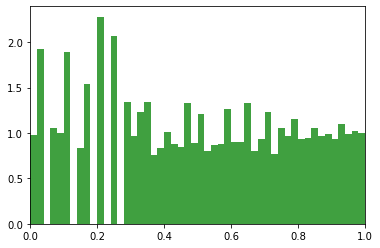

In [92]:
plt.hist(len_aTagContent_qt, 50,density=True, facecolor='g', alpha=0.75)
plt.xlim(0, 1)
plt.show()

The downside of using this method is that we will lose any information regarding the correlation between the distance of each point. If we think about the problem in hand, it is a fair assumption that this correlation should not be relevant. We will move forward using this strategy keeping in mind that there is a improvement opportunity here.

In [93]:
df['len_aTagContent_qt'] = len_aTagContent_qt

<Figure size 648x432 with 0 Axes>

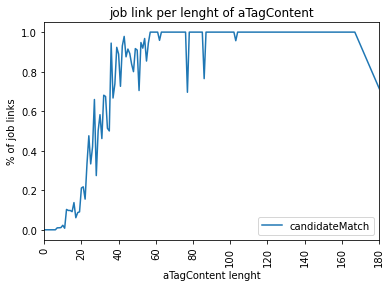

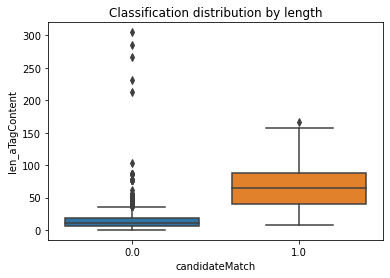

In [94]:
matches = df[['len_aTagContent','candidateMatch']].groupby('len_aTagContent').agg('mean')

# Ploting a line to check the correlation between the length of aTagContent and job links
plt.figure(figsize=(9,6))
matches.plot.line()
plt.xlim(0, 180)
plt.xticks(rotation=90)
plt.xlabel("aTagContent lenght")
plt.ylabel("% of job links")
plt.title("job link per lenght of aTagContent")
plt.show()

# Boxplot to check the distribution of job links per aTagContent length
ax = sns.boxplot(x='candidateMatch', y='len_aTagContent', data=df).set_title('Classification distribution by length')

Apparantly there is a good correlation between the length of aTagContent and candidateMatch. Since this correlation is not linear, let's create some groups of lengths. Let's also get the dummies for this new categorical feature.

In [95]:
df['len_aTagContent_group'] = np.where(df['len_aTagContent']<60,'under 60',
                                np.where(df['len_aTagContent']<=175,'between 60 and 175',
                                         'over 175'
                                         )
                                )

df = pd.get_dummies(df,columns=['len_aTagContent_group'])

In [96]:
df.head()

,aTagContent,href,keys,attributes,key_attr,trun_href,candidateMatch,len_aTagContent,len_aTagContent_qt,len_aTagContent_group_between 60 and 175,len_aTagContent_group_over 175,len_aTagContent_group_under 60
0,Skip to Content,#Main,"dict_keys(['class', 'data-ga-event', 'data-ga-...","dict_values([['in-page-link', 'skip-to-main', ...","{'class': ['in-page-link', 'skip-to-main', 'vi...",#Main,0.0,15,0.376376,0,0,1
1,\nShopify Careers \n,/careers,"dict_keys(['href', 'class', 'data-ga-event', '...","dict_values(['/careers', ['marketing-nav__logo...","{'href': '/careers', 'class': ['marketing-nav_...",/careers,0.0,19,0.446947,0,0,1
2,Life at Shopify,/careers/culture,"dict_keys(['href', 'class', 'itemprop'])","dict_values(['/careers/culture', ['marketing-n...","{'href': '/careers/culture', 'class': ['market...",/careers/culture,0.0,15,0.376376,0,0,1
3,Teams,/careers/teams,"dict_keys(['href', 'class', 'itemprop'])","dict_values(['/careers/teams', ['marketing-nav...","{'href': '/careers/teams', 'class': ['marketin...",/careers/teams,0.0,5,0.117618,0,0,1
4,Work anywhere,/careers/work-anywhere,"dict_keys(['href', 'class', 'itemprop'])","dict_values(['/careers/work-anywhere', ['marke...","{'href': '/careers/work-anywhere', 'class': ['...",/careers/work-anywhere,0.0,13,0.334835,0,0,1


# href

In [26]:
# 1 - get len
# 2 - group len

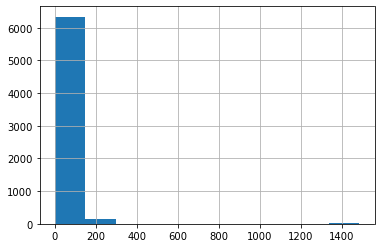

In [97]:
# Creating the len feature
df['len_href'] = df['href'].apply(lambda x: len(x) if type(x)==str else 0)

# ploting the hist for len_href

df['len_href'].hist()

Again we will need to normalize the data using a method that is not sensitive to outliers. But first last take a look to check if there is anything wrong with the dataset.

In [98]:
# let's check this 1400 char long href
print(len(df[df.len_href>1200].index))
df[df.len_href>1200]

25


,aTagContent,href,keys,attributes,key_attr,trun_href,candidateMatch,len_aTagContent,len_aTagContent_qt,len_aTagContent_group_between 60 and 175,len_aTagContent_group_over 175,len_aTagContent_group_under 60,len_href
1934,Next,/careers/jobs/?offices%5B0%5D=Altoona%2C+IA&of...,"dict_keys(['role', 'class', 'href', 'id'])","dict_values(['button', ['_42ft', '_3nu9', '_3n...","{'role': 'button', 'class': ['_42ft', '_3nu9',...",/careers/jobs/?offices%5B,0.0,4,0.089089,0,0,1,1484
2140,Prev,/careers/jobs/?offices%5B0%5D=Altoona%2C+IA&of...,"dict_keys(['role', 'class', 'href', 'id'])","dict_values(['button', ['_42ft', '_3nu9', '_3n...","{'role': 'button', 'class': ['_42ft', '_3nu9',...",/careers/jobs/?offices%5B,0.0,4,0.089089,0,0,1,1484
2141,Next,/careers/jobs/?offices%5B0%5D=Altoona%2C+IA&of...,"dict_keys(['role', 'class', 'href', 'id'])","dict_values(['button', ['_42ft', '_3nu9', '_3n...","{'role': 'button', 'class': ['_42ft', '_3nu9',...",/careers/jobs/?offices%5B,0.0,4,0.089089,0,0,1,1484
2347,Prev,/careers/jobs/?offices%5B0%5D=Altoona%2C+IA&of...,"dict_keys(['role', 'class', 'href', 'id'])","dict_values(['button', ['_42ft', '_3nu9', '_3n...","{'role': 'button', 'class': ['_42ft', '_3nu9',...",/careers/jobs/?offices%5B,0.0,4,0.089089,0,0,1,1484
2348,Next,/careers/jobs/?offices%5B0%5D=Altoona%2C+IA&of...,"dict_keys(['role', 'class', 'href', 'id'])","dict_values(['button', ['_42ft', '_3nu9', '_3n...","{'role': 'button', 'class': ['_42ft', '_3nu9',...",/careers/jobs/?offices%5B,0.0,4,0.089089,0,0,1,1484
2554,Prev,/careers/jobs/?offices%5B0%5D=Altoona%2C+IA&of...,"dict_keys(['role', 'class', 'href', 'id'])","dict_values(['button', ['_42ft', '_3nu9', '_3n...","{'role': 'button', 'class': ['_42ft', '_3nu9',...",/careers/jobs/?offices%5B,0.0,4,0.089089,0,0,1,1484
2555,Next,/careers/jobs/?offices%5B0%5D=Altoona%2C+IA&of...,"dict_keys(['role', 'class', 'href', 'id'])","dict_values(['button', ['_42ft', '_3nu9', '_3n...","{'role': 'button', 'class': ['_42ft', '_3nu9',...",/careers/jobs/?offices%5B,0.0,4,0.089089,0,0,1,1484
2761,Prev,/careers/jobs/?offices%5B0%5D=Altoona%2C+IA&of...,"dict_keys(['role', 'class', 'href', 'id'])","dict_values(['button', ['_42ft', '_3nu9', '_3n...","{'role': 'button', 'class': ['_42ft', '_3nu9',...",/careers/jobs/?offices%5B,0.0,4,0.089089,0,0,1,1484
2762,Next,/careers/jobs/?offices%5B0%5D=Altoona%2C+IA&of...,"dict_keys(['role', 'class', 'href', 'id'])","dict_values(['button', ['_42ft', '_3nu9', '_3n...","{'role': 'button', 'class': ['_42ft', '_3nu9',...",/careers/jobs/?offices%5B,0.0,4,0.089089,0,0,1,1484
2968,Prev,/careers/jobs/?offices%5B0%5D=Altoona%2C+IA&of...,"dict_keys(['role', 'class', 'href', 'id'])","dict_values(['button', ['_42ft', '_3nu9', '_3n...","{'role': 'button', 'class': ['_42ft', '_3nu9',...",/careers/jobs/?offices%5B,0.0,4,0.089089,0,0,1,1484


In [100]:
df['href'][1934]

'/careers/jobs/?offices%5B0%5D=Altoona%2C+IA&offices%5B1%5D=Ashburn%2C+VA&offices%5B2%5D=Atlanta%2C+GA&offices%5B3%5D=Austin%2C+TX&offices%5B4%5D=Boston%2C+MA&offices%5B5%5D=Chicago%2C+IL&offices%5B6%5D=Dallas%2C+TX&offices%5B7%5D=DeKalb%2C+IL&offices%5B8%5D=Denver%2C+CO&offices%5B9%5D=Detroit%2C+MI&offices%5B10%5D=Eagle+Mountain%2C+Utah&offices%5B11%5D=Forest+City%2C+NC&offices%5B12%5D=Fort+Worth%2C+TX&offices%5B13%5D=Fremont%2C+CA&offices%5B14%5D=Gallatin%2C+TN&offices%5B15%5D=Henrico%2C+VA&offices%5B16%5D=Huntsville%2C+AL&offices%5B17%5D=Los+Angeles%2C+CA&offices%5B18%5D=Los+Lunas%2C+NM&offices%5B19%5D=Menlo+Park%2C+CA&offices%5B20%5D=Miami%2C+Florida&offices%5B21%5D=Montreal%2C+Canada&offices%5B22%5D=Mountain+View%2C+CA&offices%5B23%5D=New+Albany%2C+OH&offices%5B24%5D=New+York%2C+NY&offices%5B25%5D=Newton+County%2C+GA&offices%5B26%5D=Northridge%2C+CA&offices%5B27%5D=Papillion%2C+NE&offices%5B28%5D=Pittsburgh%2C+PA&offices%5B29%5D=Prineville%2C+OR&offices%5B30%5D=Redmond%2C+WA&offic

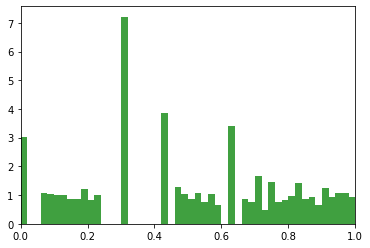

In [101]:
len_href_qt = qt.fit_transform(df.len_href.values.reshape(-1, 1))

plt.hist(len_href_qt, 50,density=True, facecolor='g', alpha=0.75)
plt.xlim(0, 1)
plt.show()

In [102]:
df['len_href_qt'] = len_href_qt

<Figure size 648x432 with 0 Axes>

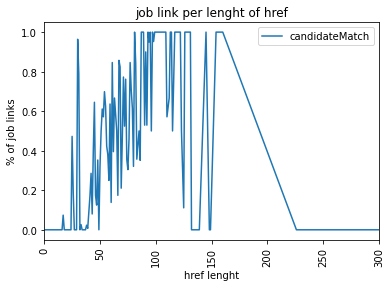

In [103]:
matches = df[['len_href','candidateMatch']].groupby('len_href').agg('mean')


plt.figure(figsize=(9,6))
matches.plot.line()
plt.xlim(0, 300)
plt.xticks(rotation=90)
plt.xlabel("href lenght")
plt.ylabel("% of job links")
plt.title("job link per lenght of href")
plt.show()

Text(0.5, 1.0, 'Boxplot len_href_qt')

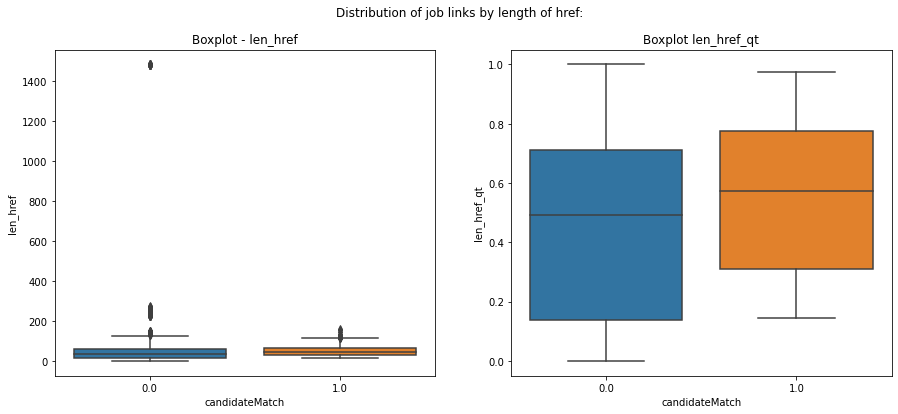

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

fig.suptitle('Distribution of job links by length of href:')

sns.boxplot(ax=axes[0], x='candidateMatch', y='len_href', data=df).set_title('Boxplot - len_href')

sns.boxplot(ax=axes[1], x='candidateMatch', y='len_href_qt', data=df).set_title('Boxplot len_href_qt')

Although there is a lot of overlap between the two classes, job links have a slightly larger hrefs. Let's separate them by groups to test if the correlation increases.

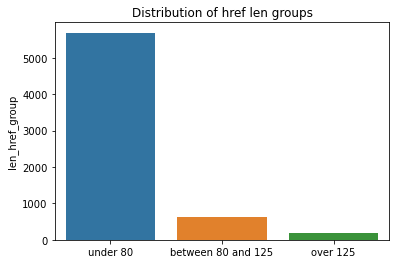

In [133]:
df['len_href_group'] = np.where(df['len_href']<80,'under 80',
                                np.where(df['len_href']<=125,'between 80 and 125',
                                         'over 125'
                                         )
                                )

# ploting the hist for len_href_group

cat_num = df['len_href_group'].value_counts()

ax = sns.barplot(x=cat_num.index,y=cat_num).set_title('Distribution of href len groups')


df = pd.get_dummies(df,columns=['len_href_group'])

# Keys

In [134]:
df['keys'].head()

0    class data-ga-event data-ga-action data-trekki...
1    href class data-ga-event data-ga-action data-t...
2                                  href class itemprop
3                                  href class itemprop
4                                  href class itemprop
Name: keys, dtype: object

1 - get rid of the dict characters - keep only keys (do not split 2 word keys).<br>
2 - evaluate how many different keys we have. <br>
3 - check keys that have a higher candidateMatch rate (over the avg of dataset). <br>
4 - add a feature: number of keys.<br>

In [135]:
# For 1, we are going to use apply with a function we have declared earlier.

chars_to_remove = ['dict_keys','(',')','[',']',',',"'"]
df['keys'] = df['keys'].apply(remove_char,list_of_chars=chars_to_remove)
df['keys'].head()

0    class data-ga-event data-ga-action data-trekki...
1    href class data-ga-event data-ga-action data-t...
2                                  href class itemprop
3                                  href class itemprop
4                                  href class itemprop
Name: keys, dtype: object

In [136]:
# checking the most frequent keys in the dataset.
keys = df['keys'].str.split(expand=True).stack().value_counts()
keys[:10]

href          6510
class         4444
style         1346
id            1275
target         972
title          717
rel            413
role           359
hreflang       303
aria-label     288
dtype: int64

As expected, href will be present in every row, since we dropped the few lines that hadn't this value. Now we need to evaluate if there is a correlation between these keys and candidateMatch.

In [137]:
perc_match = []
keys_check = []

# For every key term, we will check keys in the dataset and calculate how often they are related to a job link.
for key in keys.index:
    positive = 0
    frequency = 0
    for i in range(len(df.index)):
        
        if key in df['keys'][i]:
            frequency += 1            
            if df['candidateMatch'][i]==1:
                positive += 1
    perc_match.append(positive/frequency)
    keys_check.append(key)

df_keys = pd.DataFrame(columns=['keys','perc_match','above_avg_match'])

# Calculating the percentege of job links in the dataset
candidateMatch_frequency = (df['candidateMatch'].sum() / len(df.index))

df_keys['keys'] = keys_check
df_keys['perc_match'] = perc_match

# comparing the key frequency in job links vs the avg job link % in the dataset
df_keys['above_avg_match'] = np.where(df_keys['perc_match']>candidateMatch_frequency,1,0)

df_keys[['keys','perc_match']].sort_values(by='perc_match',ascending=False)[0:20]

,keys,perc_match
48,data-ph-at-job-id-text,1.000000
25,"""",1.000000
36,data-ph-at-job-type-text,1.000000
37,ph-tag,1.000000
18,data-mapped,1.000000
38,data-ph-at-job-category-text,1.000000
39,data-access-list-item,1.000000
40,ph-tref,1.000000
41,href.bind,1.000000
43,data-ph-at-job-industry-text,1.000000


Let's check how these keys are distributed among companies.

In [138]:
df_backup[df_backup['keys'].str.contains('style')]['company'].value_counts().head()

Facebook      1300
scotiabank      16
later            9
opentext         6
Oracle           6
Name: company, dtype: int64

In [139]:
df_backup[df_backup['keys'].str.contains('hreflang')]['company'].value_counts().head()

Okta    303
Name: company, dtype: int64

The most relevant keys are associated with basically one company, so we should not add this as a feature. Instead, there is a chance the word 'job' will be relevant, since it has a great correlation.

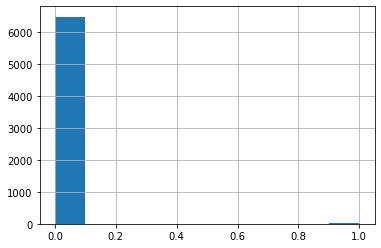

In [140]:
df['key_job_yn'] = np.where(df['keys'].str.contains('job'),1,0)

df['key_job_yn'].hist()

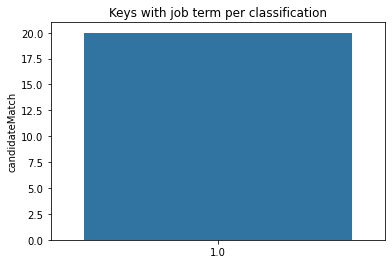

In [125]:
# ploting the hist for len_href_group

cat_num = df[df['key_job_yn']==1]['candidateMatch'].value_counts()

ax = sns.barplot(x=cat_num.index,y=cat_num).set_title('Keys with job term per classification')

It is not present in many rows, but let's keep this column for now since it always indicates job links. We will handle it later.

We can also add a 'number of keys' feature

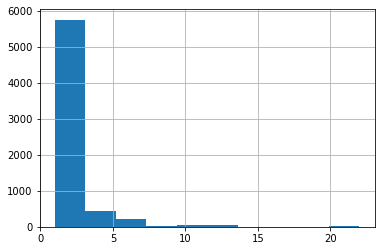

In [126]:
df['num_keys'] = df['keys'].apply(lambda x: len(x.split()))


df['num_keys'].hist()

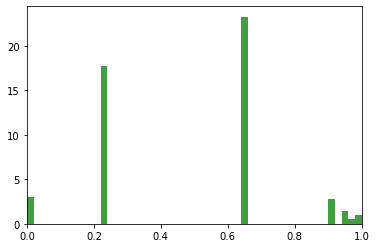

In [127]:
num_keys_qt = qt.fit_transform(df.num_keys.values.reshape(-1, 1))

df['num_keys_qt'] = len_href_qt

plt.hist(num_keys_qt, 50,density=True, facecolor='g', alpha=0.75)
plt.xlim(0, 1)
plt.show()

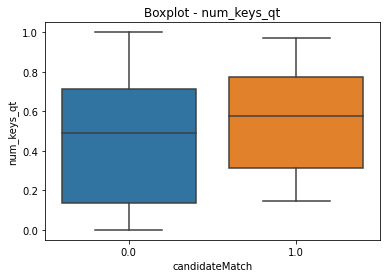

In [128]:
ax = sns.boxplot(x='candidateMatch', y='num_keys_qt', data=df).set_title('Boxplot - num_keys_qt')

# Attributes

In [129]:
df['attributes'].head()

0    dict_values([['in-page-link', 'skip-to-main', ...
1    dict_values(['/careers', ['marketing-nav__logo...
2    dict_values(['/careers/culture', ['marketing-n...
3    dict_values(['/careers/teams', ['marketing-nav...
4    dict_values(['/careers/work-anywhere', ['marke...
Name: attributes, dtype: object

1 - The href is repeated in every single line, we should get rid of it.<br>
2 - use a similar approach we used for keys.<br>

In [130]:
# using a custom function to remove the href from the attributes
df['attributes'] = df[['attributes','href']].apply(extract_href,axis=1)

# expliciting the characters we want to remove at this point (we don't want to break single attr in different words yet)
chars_to_remove = ['dict_values','(',')','[',']',',',"'"]

# removing thee special chras using a custom function
df['attributes'] = df['attributes'].apply(remove_char,list_of_chars=chars_to_remove)

df['attributes'].head()

0    in-page-link skip-to-main visuallyhidden focus...
1     marketing-nav__logo__shopify Main Nav Logo Ma...
2     marketing-nav__item marketing-nav__item--prim...
3     marketing-nav__item marketing-nav__item--prim...
4     marketing-nav__item marketing-nav__item--prim...
Name: attributes, dtype: object

In [131]:
attrs = df['attributes'].str.split(expand=True).stack().value_counts()
len(attrs)

1618

In [141]:
# Since we have too many attrs, let's only check the relevance of the top 100 more frequent

attrs = df['attributes'].str.split(expand=True).stack().value_counts()[:100]

perc_match = []
attrs_check = []

for attr in attrs.index:
    positive = 0
    frequency = 0
    for i in range(len(df.index)):
        
        if attr in df['attributes'][i]:
            frequency += 1            
            if df['candidateMatch'][i]==1:
                positive += 1
    perc_match.append(positive/frequency)
    attrs_check.append(attr)

df_attrs = pd.DataFrame(columns=['attrs','perc_match','above_avg_match'])

candidateMatch_frequency = (df['candidateMatch'].sum() / len(df.index))

df_attrs['attrs'] = attrs_check
df_attrs['perc_match'] = perc_match
df_attrs['above_avg_match'] = np.where(df_attrs['perc_match']>candidateMatch_frequency,1,0)

df_attrs[['attrs','perc_match']].sort_values(by='perc_match',ascending=False)[0:20]

,attrs,perc_match
0,_8sef,1.000000
90,"eachJob.jobUrl""",1.000000
1,text-decoration:none;,1.000000
29,posting:,1.000000
28,color-cyan-70,1.000000
19,posting-title,1.000000
15,lever-job-title,1.000000
89,"""getUrllinkEle",1.000000
35,job-title,1.000000
94,eachJob,1.000000


Again, let's check how these attributes are distributed among companies.

In [142]:
df_backup[df_backup['attributes'].str.contains('jobTitle-link')]['company'].value_counts()

scotiabank    400
opentext       50
Name: company, dtype: int64

In [143]:
df_backup[df_backup['attributes'].str.contains('linkEle')]['company'].value_counts()

yelp         12
Snowflake    12
Name: company, dtype: int64

Again, there is a high chance of overfiting the model, let's add a "job" feature instead.

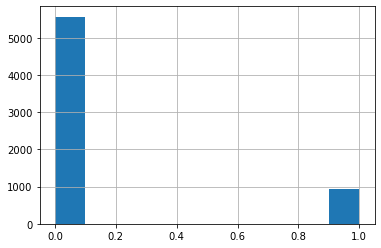

In [144]:
df['attr_job_yn'] = np.where(df['attributes'].str.contains('Job|job'),1,0)

df['attr_job_yn'].hist()

In [146]:
df_backup[df['attributes'].str.contains('job')]['company'].value_counts()

scotiabank        424
glu               156
shopify            76
opentext           56
loblawdigital      47
Ernest & young     35
Oracle             27
Snowflake          23
loopio             19
later              14
Facebook           13
yelp               11
remine              8
sensibill           8
mavencare           1
Name: company, dtype: int64

# key_attr

This column will be a copy of the previous two. Since we are focusing in simplicity here, we will not check the relevance between key and attr.

In [49]:
df = df.drop('key_attr',axis='columns')

# trun_href

This is a "incomplete" version of href.

In [50]:
df = df.drop('trun_href',axis='columns')

# Advanced feature engineering

We have two goals here <br> 
1 - Evaluate the correlation and relevance of the features we have. <br>
2 - Create a tolkenizer to extract the maximum value of text based features.

In [51]:
# removing the remaining special characteres that were kept to avoid breaking keys and attrs

df['aTagContent'] = df['aTagContent'].apply(specialCharCleaner)
df['href'] = df['href'].apply(specialCharCleaner)
df['keys'] = df['keys'].apply(specialCharCleaner)
df['attributes'] = df['attributes'].apply(specialCharCleaner)

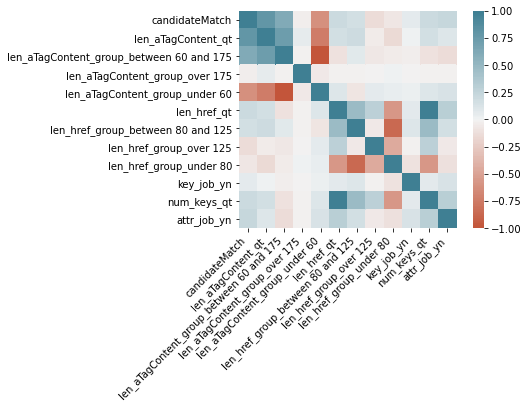

In [52]:
heat_map(df[['candidateMatch',
       'len_aTagContent_qt', 'len_aTagContent_group_between 60 and 175',
       'len_aTagContent_group_over 175', 'len_aTagContent_group_under 60',
       'len_href_qt', 'len_href_group_between 80 and 125',
       'len_href_group_over 125', 'len_href_group_under 80', 'key_job_yn',
       'num_keys_qt', 'attr_job_yn']])

Although we already have a good POV of the most relevant features, let's try a different approach. We are going to create a random feature, run a simple model and check which features can be discarted.

In [66]:
np.random.seed(42)

# Creating a column with random values
df['random_feature'] = np.random.rand(len(df.index))

y = df['candidateMatch']
X = df[['len_aTagContent_qt', 'len_aTagContent_group_between 60 and 175',
       'len_aTagContent_group_over 175', 'len_aTagContent_group_under 60',
       'len_href_qt', 'len_href_group_between 80 and 125',
       'len_href_group_over 125', 'len_href_group_under 80', 'key_job_yn',
       'num_keys_qt', 'attr_job_yn', 'random_feature']]


# We are going to use the random forest to take advantage of the feature importances.
rfc = RandomForestClassifier(max_depth=8,n_estimators=100)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rfc.fit(X_train,y_train)

prediction = rfc.predict(X_test)

print('Accuracy Score:  ', accuracy_score(prediction,y_test))

importances = rfc.feature_importances_

df_importances = pd.DataFrame({'feature':X.columns, 'importance':importances})

print(df_importances.sort_values(by='importance',ascending=False))

Accuracy Score:   0.9523809523809523
                                     feature  importance
0                         len_aTagContent_qt    0.459708
1   len_aTagContent_group_between 60 and 175    0.143057
9                                num_keys_qt    0.126835
3             len_aTagContent_group_under 60    0.105356
4                                len_href_qt    0.095086
10                               attr_job_yn    0.034381
11                            random_feature    0.013053
6                    len_href_group_over 125    0.010891
5          len_href_group_between 80 and 125    0.006533
7                    len_href_group_under 80    0.004098
2             len_aTagContent_group_over 175    0.000550
8                                 key_job_yn    0.000451


First, we got a really good accuracy, even before creating more advanced features or tunning the hyperparameters. Second, there are clearly some features adding no value to the model, since their importance was lower than the random feature we created, let's drop them.

In [ ]:
drop_features = []

for i in range(len(df_importances.index)):
    if df_importances['importance'][i] <= df_importances['importance'][11]:
        drop_features.append(df_importances['feature'][i])

df = df.drop(drop_features,axis='columns')

In [53]:
df.head()

,aTagContent,href,keys,attributes,candidateMatch,len_aTagContent,len_aTagContent_qt,len_aTagContent_group_between 60 and 175,len_aTagContent_group_over 175,len_aTagContent_group_under 60,len_href,len_href_qt,len_href_group_between 80 and 125,len_href_group_over 125,len_href_group_under 80,key_job_yn,num_keys,num_keys_qt,attr_job_yn
0,Skip to Content,Main,class data ga event data ga action data trekki...,in page link skip to main visuallyhidden focus...,0.0,15,0.376376,0,0,1,5,0.063564,0,0,1,0,7,0.063564,0
1,Shopify Careers,careers,href class data ga event data ga action data t...,marketing nav logo shopify Main Nav Logo Main...,0.0,19,0.446947,0,0,1,8,0.077578,0,0,1,0,7,0.077578,0
2,Life at Shopify,careers culture,href class itemprop,marketing nav item marketing nav item primary...,0.0,15,0.376376,0,0,1,16,0.138639,0,0,1,0,3,0.138639,0
3,Teams,careers teams,href class itemprop,marketing nav item marketing nav item primary...,0.0,5,0.117618,0,0,1,14,0.125125,0,0,1,0,3,0.125125,0
4,Work anywhere,careers work anywhere,href class itemprop,marketing nav item marketing nav item primary...,0.0,13,0.334835,0,0,1,22,0.174174,0,0,1,0,3,0.174174,0


We still need to handle the first 4 columns, which are categorical. Let's put them all together so we can <b>create tolkens</b>.

In [54]:
# using a custom function to concat all the relevant columns
df['all_text'] = df[['aTagContent', 'href', 'keys', 'attributes']].apply(connect_columns,axis=1)

In [55]:
# checking if we got everything write
print(df[df.all_text.isna()][['all_text','aTagContent', 'href', 'keys', 'attributes']].head())

Empty DataFrame
Columns: [all_text, aTagContent, href, keys, attributes]
Index: []


In [56]:
# Now that we have this combined column, we need to get rid of numbers and spaces before creating tolkens
df['all_text'] = df['all_text'].apply(remove_numbers)

In [57]:
# We can now drop those columns
df.drop(['aTagContent', 'href', 'keys', 'attributes'],axis='columns',inplace=True)

In [58]:
# and these too
df.drop(['len_aTagContent', 'len_href', 'num_keys'],axis='columns',inplace=True)

In [59]:
df.head()

,candidateMatch,len_aTagContent_qt,len_aTagContent_group_between 60 and 175,len_aTagContent_group_over 175,len_aTagContent_group_under 60,len_href_qt,len_href_group_between 80 and 125,len_href_group_over 125,len_href_group_under 80,key_job_yn,num_keys_qt,attr_job_yn,all_text
0,0.0,0.376376,0,0,1,0.063564,0,0,1,0,0.063564,0,Skip to Content Main class data ga event data ...
1,0.0,0.446947,0,0,1,0.077578,0,0,1,0,0.077578,0,Shopify Careers careers href class data ga ev...
2,0.0,0.376376,0,0,1,0.138639,0,0,1,0,0.138639,0,Life at Shopify careers culture href class ite...
3,0.0,0.117618,0,0,1,0.125125,0,0,1,0,0.125125,0,Teams careers teams href class itemprop market...
4,0.0,0.334835,0,0,1,0.174174,0,0,1,0,0.174174,0,Work anywhere careers work anywhere href class...


In [60]:
# Let's save a version of this dataframe without tolkens so we can run more simple models.

now = datetime.datetime.now()
today = datetime.datetime.today()

date = today.strftime("%Y-%m-%d")
hour = now.strftime("%H")
minute = now.strftime("%M")

stamp = str(date) + ' ' + str(hour) + 'h' + str(minute)

df.to_csv(str(stamp)+r'dataset_pre_tolken.csv', index=False)

<h4> Now let's create the tolkens </h4>

In [61]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_df=0.95)

tokens = tfidf_vectorizer.fit_transform(df['all_text'])

print('Tokens shape: ', tokens.shape)

Tokens shape:  (6510, 4580)


In [62]:
# Let's connect it to the data frame

df1 = pd.DataFrame(tokens.toarray(), columns=tfidf_vectorizer.get_feature_names())

X = pd.concat([df, df1], axis=1)

print('shape of X: ', X.shape)

X.drop('all_text',inplace=True,axis='columns')

print(X.head())

shape of X:  (6510, 4593)
   candidateMatch  len_aTagContent_qt  \
0             0.0            0.376376   
1             0.0            0.446947   
2             0.0            0.376376   
3             0.0            0.117618   
4             0.0            0.334835   

   len_aTagContent_group_between 60 and 175  len_aTagContent_group_over 175  \
0                                         0                               0   
1                                         0                               0   
2                                         0                               0   
3                                         0                               0   
4                                         0                               0   

   len_aTagContent_group_under 60  len_href_qt  \
0                               1     0.063564   
1                               1     0.077578   
2                               1     0.138639   
3                               1     0.125125   
4 

In [63]:
# Since this is a havier dataset, with relevant info, let's save it in a special format

X.to_pickle(str(stamp)+r'dataset_with_tolkens.pkl')